In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/depression-dataset/depression_data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("/kaggle/input/depression-dataset/depression_data.csv")


In [4]:
df.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [5]:
df.columns

Index(['Name', 'Age', 'Marital Status', 'Education Level',
       'Number of Children', 'Smoking Status', 'Physical Activity Level',
       'Employment Status', 'Income', 'Alcohol Consumption', 'Dietary Habits',
       'Sleep Patterns', 'History of Mental Illness',
       'History of Substance Abuse', 'Family History of Depression',
       'Chronic Medical Conditions'],
      dtype='object')

In [6]:
def number_of_unique(df):
    for i in df:
        print(str(i) + " column," + " number of unique is " + str(df[i].nunique()))

In [7]:
number_of_unique(df)


Name column, number of unique is 196851
Age column, number of unique is 63
Marital Status column, number of unique is 4
Education Level column, number of unique is 5
Number of Children column, number of unique is 5
Smoking Status column, number of unique is 3
Physical Activity Level column, number of unique is 3
Employment Status column, number of unique is 2
Income column, number of unique is 405282
Alcohol Consumption column, number of unique is 3
Dietary Habits column, number of unique is 3
Sleep Patterns column, number of unique is 3
History of Mental Illness column, number of unique is 2
History of Substance Abuse column, number of unique is 2
Family History of Depression column, number of unique is 2
Chronic Medical Conditions column, number of unique is 2


In [8]:
df.isnull().sum()  ## there are no null values


Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [10]:
df["Chronic Medical Conditions"].value_counts()


Chronic Medical Conditions
No     277561
Yes    136207
Name: count, dtype: int64

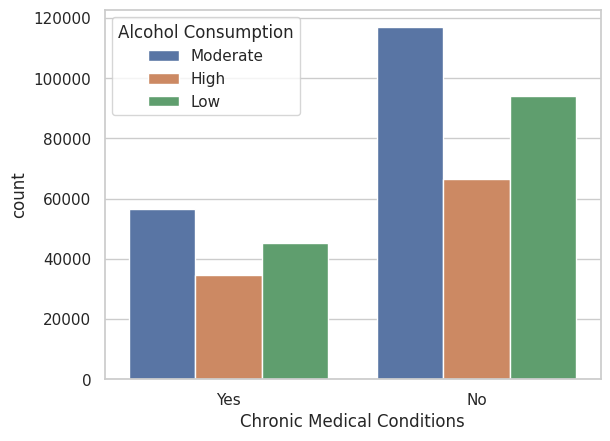

In [11]:
sns.set(style = "whitegrid")
sns.countplot(x = "Chronic Medical Conditions", hue = "Alcohol Consumption", data = df);

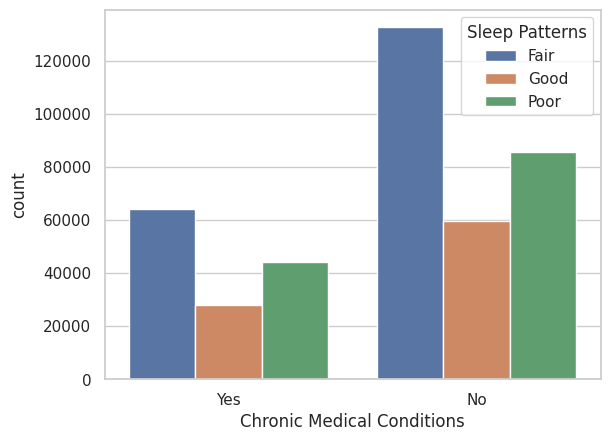

In [12]:
sns.countplot(x = "Chronic Medical Conditions", hue = "Sleep Patterns", data = df);


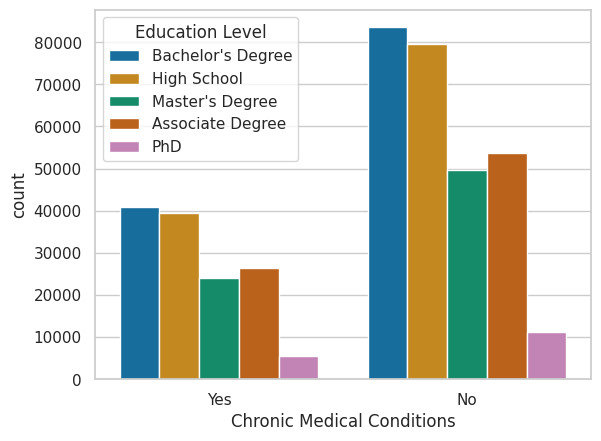

In [13]:
sns.countplot(x = "Chronic Medical Conditions", hue = 'Education Level', data = df, palette="colorblind");

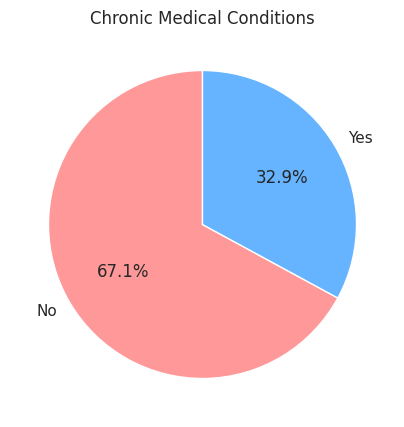

In [14]:
plt.figure(figsize = (5,5))
df["Chronic Medical Conditions"].value_counts().plot.pie(autopct="%1.1f%%", startangle = 90,
                                      colors = ['#ff9999','#66b3ff'])
plt.title("Chronic Medical Conditions")
plt.ylabel("")
plt.show()

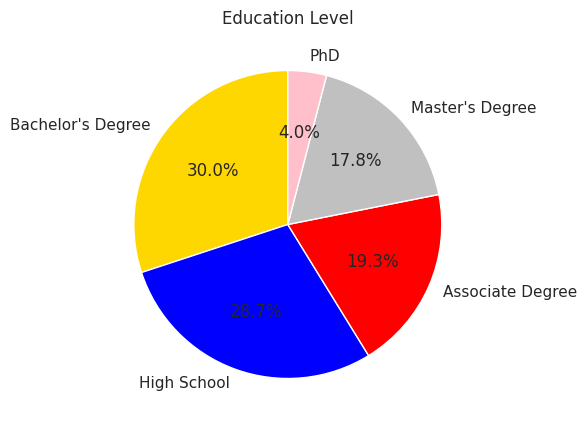

In [15]:
plt.figure(figsize = (5,5))
df["Education Level"].value_counts().plot.pie(autopct="%1.1f%%", startangle = 90,
                                      colors = ['gold','blue','red','silver',"pink"])
plt.title("Education Level")
plt.ylabel("")
plt.show()

In [16]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [17]:
col = ['Marital Status', 'Education Level', 'Employment Status', 'Smoking Status', 'Physical Activity Level', "Employment Status", 'Alcohol Consumption',
      'Dietary Habits', 'Sleep Patterns', 'History of Mental Illness', "History of Substance Abuse", 'Family History of Depression', 'Chronic Medical Conditions']

In [18]:
for i in col:
    df = label_encoder(df, i)

In [19]:
df.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,1,1,2,2,0,1,26265.67,2,1,0,1,0,1,1
1,Jacqueline Lewis,55,1,2,1,2,2,0,42710.36,0,2,0,1,0,0,1
2,Shannon Church,78,3,3,1,2,2,0,125332.79,1,2,1,0,0,1,0
3,Charles Jordan,58,0,3,3,2,1,1,9992.78,2,1,2,0,0,0,0
4,Michael Rich,18,2,2,0,2,2,1,8595.08,1,1,0,1,0,1,1


In [20]:
df.drop(["Name"], axis = 1, inplace = True)


In [21]:
X = df.drop(['Chronic Medical Conditions'], axis = 1)
y = df['Chronic Medical Conditions']

In [22]:
X_copy = X.copy()


In [23]:
Scaler = StandardScaler()
X = Scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
model = LGBMClassifier().fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 108965, number of negative: 222049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 331014, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329185 -> initscore=-0.711871
[LightGBM] [Info] Start training from score -0.711871


In [26]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)


0.6707832854001015

In [27]:
model.feature_importances_


array([664, 104, 147, 175, 148, 135,  32, 835, 163, 146, 170,  97, 104,
        80], dtype=int32)

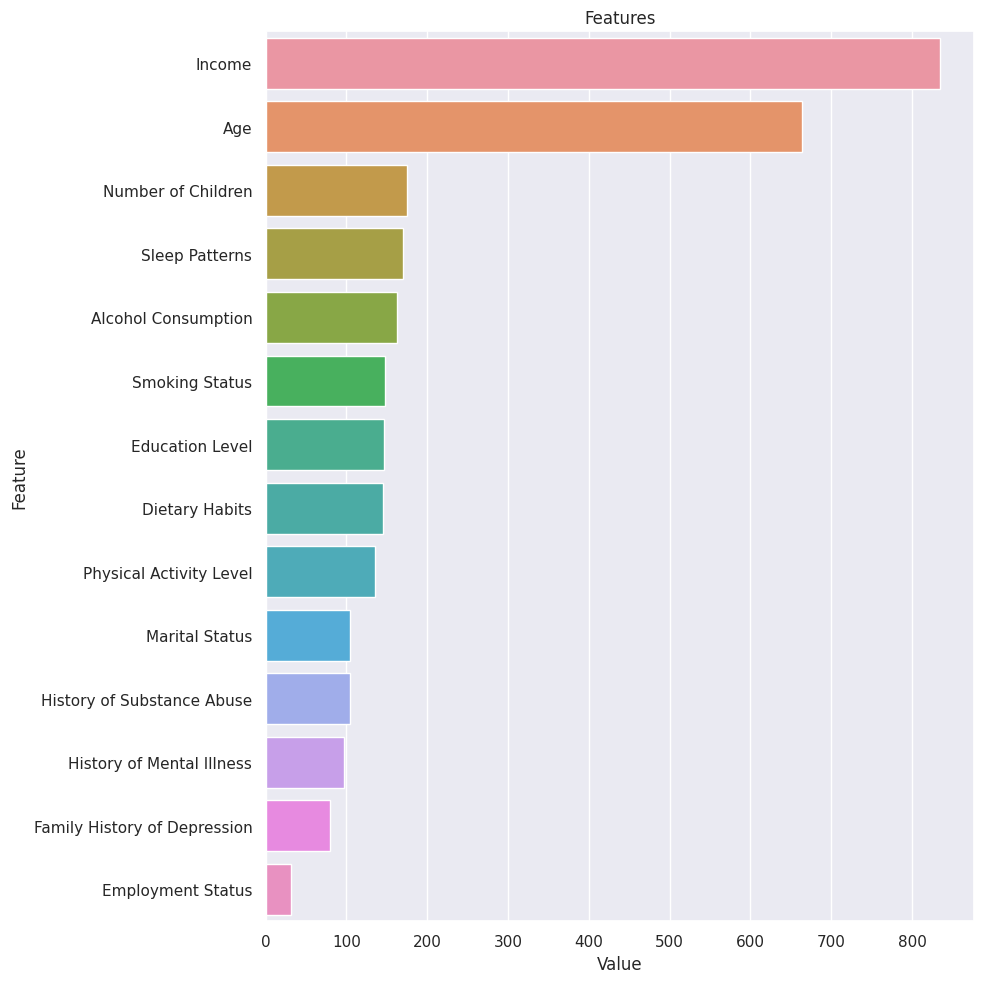

In [28]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(model, X_copy)
